In [99]:
%reload_ext autoreload

In [100]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import random
import csv
import pandas as pd

from fastai.imports import *
from fastai.structured import *
from matplotlib import pyplot
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import csv

sys.path.append('../lib')
import utils
import preprocessing

In [102]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

# Delete rubbish rows
rubbish_rows = ['tobias-tattoo-a.neto.com.au', 'www.lovesongs.com.au', 'vantage-demo.neto.com.au', 'marshall.neto.com.au']

for url in rubbish_rows:
    loc = df_raw[df_raw.url == url].index[0]
    df_raw = df_raw.drop([loc], axis=0)

In [103]:
print(len(df_raw.loc[df_raw.churned == 0]), df_raw.loc[df_raw.churned == 0].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[(df_raw.licence_status != "STAGING") & (df_raw.plan != "CUSTOM")])
print(len(df_processed), df_processed.shape)

df_filtered = df_processed.loc[df_processed.churned == 0]
df_data, y_data, nas = proc_df(df_filtered, 'churned')
print(len(df_data), df_data.shape)

2776 (2776, 37)
Sorting dataframe by licence_registration_date ...
Converting annual_revenue to a number ...
Defaulting all NaN values with median ...
Defaulting annual_revenue for missing values to the plans mean or platform medeian ...
 Platform revenue median: 62885.175
Binning last_login_days
day          4492
month+        765
few_days       74
week           71
fortnight      65
month          51
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
Preprocessing dates ...


ValueError: mixed datetimes and integers in passed array

In [90]:
df_filtered.loc[(df_filtered.annual_revenue == 0) & (df_filtered['plan_PLAN-M-19Q1'] == 1)]

,username,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,...,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed
1994,N019585,1250,not specified,Motor Parts,richard,247,1,0,0,0,...,25,2,25,False,False,False,False,False,False,1485302400
4236,N051363,743,not specified,Wholesale,rene,5,3,0,0,91,...,17,1,290,False,False,False,False,False,False,1508198400
5594,N062800,233,not specified,Homewares,peter.rogan,56,19,1,1,5145,...,1,2,121,False,True,False,False,False,False,1556668800
5688,N063498,182,Team Imagine,not specified,richard,-1,13,3,3,7768,...,1,3,1,False,True,False,True,False,True,0
5709,N064149,170,not specified,Wholesale,peter.rogan,-1,9,0,0,1706,...,1,3,1,False,True,False,True,False,True,0
5725,N064494,158,Team Aspire,Homewares,peter.rogan,8,4,1,1,2078,...,28,1,148,False,False,False,False,False,False,1559001600
5796,N064598,121,Standard Support,Health & Beauty,jackson.mcculloch,-1,20,3,3,5293,...,1,3,1,False,True,False,True,False,True,0


In [62]:
joblib_file = "churn_model.pkl"

# Load from file
churn_model = joblib.load(joblib_file)

In [63]:
predictions = churn_model.predict(df_data)
probability = churn_model.predict_proba(df_data)[:,1]
len(probability), len(predictions), len(df_filtered)

(2419, 2419, 2419)

In [64]:
df_predictions = pd.DataFrame(predictions)
df_probability = pd.DataFrame(probability)

In [65]:
df_output = df_processed[df_processed.churned == 0].copy()

In [66]:
df_output['prediction'] = predictions
df_output['probability'] = probability

In [67]:
# Calculate churn concern %
churn_concern_count = len(df_output.loc[df_output['prediction'] == 1])
total_active = len(df_output)
churn_concern_percent = round((churn_concern_count / total_active) * 100, 2)
print(f"Churn concern count: {churn_concern_count} of {total_active} ({churn_concern_percent}%)")

Churn concern count: 138 of 2419 (5.7%)


In [68]:
# Sort churn concerns by probability
df_sorted = df_output.loc[df_output['prediction'] == 1].sort_values(by=['probability'], ascending=False)

In [69]:
#df_output.annual_revenue_log.var(), df_output.annual_revenue_log.skew(), df_output.annual_revenue_log.mad(), df_output.annual_revenue_log.mode()



In [70]:
now = datetime.datetime.now()

record_count = len(df_sorted.loc[df_sorted['probability'] > 0.0])
print(record_count)

for i in range(record_count):
#for i in range(len(df_sorted)):
    print(f"{now},{df_sorted.username.iloc[i]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].url.iloc[0]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].plan.iloc[0]},{df_sorted.licence_registration_Year.iloc[i]},{df_sorted.annual_revenue.iloc[i]},{df_sorted.probability.iloc[i]}")
    #with open('../data/predictions.csv', 'w') as writeFile:
    #    writer = csv.writer(writeFile)
    #    writer.writerows(sorted_array)

#writeFile.close()

138
2019-10-25 07:27:41.685517,N063095,www.kindwaysocks.com,PLAN-S-19Q1,2019,0.0,0.8361926561758197
2019-10-25 07:27:41.685517,N060830,www.5red.com.au,PLAN-S-17Q2,2018,0.0,0.8123837246353892
2019-10-25 07:27:41.685517,N061402,zoomautoparts.neto.com.au,PLAN-360-19Q1,2019,0.0,0.7809871313384454
2019-10-25 07:27:41.685517,N059650,www.barttap.es,PLAN-360-17Q2,2018,124.49,0.7569298251235954
2019-10-25 07:27:41.685517,N059456,www.esco-furniture.com,PLAN-S-17Q2,2018,0.0,0.7529643350448219
2019-10-25 07:27:41.685517,N062334,www.uniquepartyshop.com.au,PLAN-M-19Q1,2019,4451.42,0.7528952809592794
2019-10-25 07:27:41.685517,N037999,neto-nz-1.neto.com.au,PLAN-L,2017,0.0,0.7514049985013052
2019-10-25 07:27:41.685517,N063144,www.sydneysupplies.com.au,PLAN-M-19Q1,2019,1843.2,0.750013783203059
2019-10-25 07:27:41.685517,N061994,invidia-exhausts.com.au,PLAN-S-19Q1,2019,70029.68,0.7183528940041801
2019-10-25 07:27:41.685517,N059535,www.techtoppers.com.au,PLAN-S-19Q1,2018,1455.48,0.7165494647937409
2019-1

2019-10-25 07:27:41.685517,N062700,www.kyca.com.au,PLAN-M-19Q1,2019,7586.05,0.5246003098940147
2019-10-25 07:27:41.685517,N059953,iquay.neto.com.au,PLAN-S-19Q1,2018,0.0,0.5241628388012338
2019-10-25 07:27:41.685517,N061144,www.rideline.com.au,PLAN-L-19Q1,2018,63001.85,0.5241240897454053
2019-10-25 07:27:41.685517,N065884,www.kidmart.com.au,PLAN-S-19Q1,2019,0.0,0.5224278879425361
2019-10-25 07:27:41.685517,N028791,slaa-sydney-int.neto.com.au,PLAN-S,2016,7534.87,0.5214423969017195
2019-10-25 07:27:41.685517,N055207,www.barteltrailersshop.com.au,PLAN-S-19Q1,2019,474.04,0.5212778055590492
2019-10-25 07:27:41.685517,N030565,the-book-mill-o.neto.com.au,PLAN-L-19Q1,2016,31583.84,0.5210041863585271
2019-10-25 07:27:41.685517,N059293,www.creativehampers.com.au,PLAN-L-19Q1,2018,460926.75,0.5209349243244688
2019-10-25 07:27:41.685517,N063322,www.willowandink.com.au,PLAN-S-19Q1,2019,0.0,0.5175651352583486
2019-10-25 07:27:41.685517,N062429,www.tomscap.com.au,PLAN-S-19Q1,2019,0.0,0.5167328517374642

In [71]:
n_number = 'N063095'
utils.display_all(df_filtered[df_filtered.username == n_number])

,username,days_active,team,vertical,salesperson,golive_days,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,annual_revenue,churned,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,last_login_days_was_nan,plan_not_set,annual_revenue_was_missing,last_login_categories,days_active_modified,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIUM,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TRIAL,plan_ULTIMATE,plan_ULTIMATE PLUS,plan_no_plan,nps_no_data,nps_detractor,nps_passive,nps_promoter,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed,golive_Year,golive_Month,golive_Week,golive_Day,golive_Dayofweek,golive_Dayofyear,golive_Is_month_end,golive_Is_month_start,golive_Is_quarter_end,golive_Is_quarter_start,golive_Is_year_end,golive_Is_year_start,golive_Elapsed
5754,N063095,144,Team Vision,Fashion & Sales,simon.white,-1,4,0,0,824,249,0.0,0,1,1,1,1,1,1,0,1,month+,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2019,6,23,3,0,154,False,False,False,False,False,False,1559520000,1970,1,1,1,3,1,False,True,False,True,False,True,0


In [72]:
from eli5 import show_prediction
loc_address = df_filtered[df_filtered.username == n_number].index[0]
show_prediction(churn_model, df_data.loc[loc_address], show_feature_values=True)

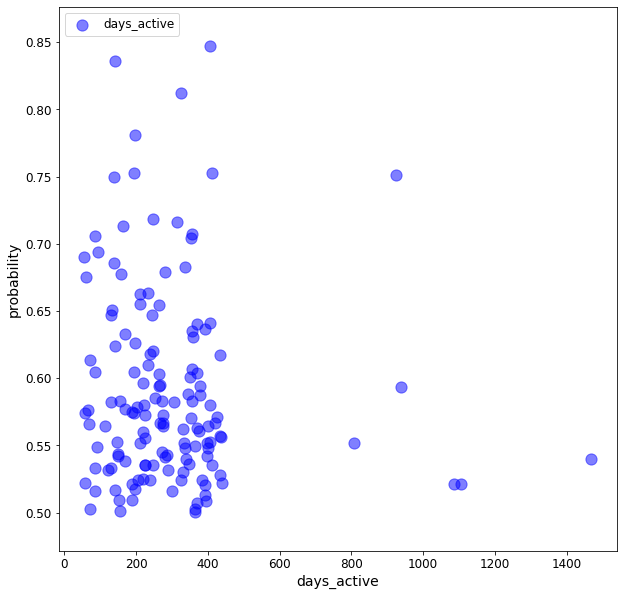

In [46]:
import matplotlib.pyplot as plt

feature='days_active'

plt.figure(figsize=(10,10))
plt.scatter(df_sorted[feature], df_sorted['probability'],
            c='b', marker='.', label=feature,
            s=500, alpha=.5)

plt.legend(loc='upper left')
plt.xlabel(feature)
plt.ylabel("probability")

plt.show()

In [17]:
print(df_sorted[feature].mode())

0    136
1    208
dtype: int64


In [18]:
def general_stats(df, feature):
    array = utils.data_summary_feature(df, feature)
    print(array[0])
    print("")
    count = 1
    for heading in ['Min', 'Max', 'Mean', 'Trimmed Mean', 'Median', 'Mode', 'Std', 'CV']:
        print(f"{heading}: {array[count]}")
        count += 1
        
general_stats(df_sorted,feature)

days_active

Min: 52
Max: 1705
Mean: 457.95454545454544
Trimmed Mean: 381.30555555555554
Median: 252.0
Mode: 0    136
1    208
dtype: int64
Std: 460.1027162642512
CV: 1.0046907948202013
